In [45]:
import numpy as np

full_data = np.load('./data/full_data.npy', allow_pickle=True)
X_train_event, X_test_event, X_train_obj, X_test_obj, y_train, y_test = full_data

In [46]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model("./RNN_tuned_model")
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 14, 8)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 126)               68040     
_________________________________________________________________
layer_normalization_1 (Layer (None, 126)               252       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 127       
Total params: 68,419
Trainable params: 68,419
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Imbalanced dataset so want to adjusts weights of signal and background training examples
tot = len(y_train)
sg_weight = (1 / np.sum(y_train['ttH125'])) * (tot / 2)
sl_weight = (1 / np.sum(y_train['TTToSemiLeptonic'])) * (tot / 2)
dl_weight = (1 / np.sum(y_train['TTTo2L2Nu'])) * (tot / 2)
fh_weight = (1 / np.sum(y_train['TTToHadronic'])) * (tot / 2)

y_train, y_test = y_train.values, y_test.values
weights = {0: dl_weight, 1: fh_weight, 2: sl_weight, 3:sg_weight}
train_weights, test_weights = np.array([weights[np.argmax(event)] for event in y_train]), np.array([weights[np.argmax(event)] for event in y_test])
set(train_weights)

{0.6903050890370496, 2.0591674638739237, 15.448909245443385, 997.4908536585366}

In [44]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [EarlyStopping(patience=10, restore_best_weights=True), ReduceLROnPlateau(patience=5)]
model.fit(x=X_train_obj, y=y_train[:,-1], batch_size=16, epochs=30, callbacks=callbacks, validation_data=(X_test_obj, y_test[:,-1], test_weights), sample_weight=train_weights, shuffle=True)

Epoch 1/30
20449/20449 [==============================] - 124s 6ms/step - loss: 1.1436 - auc_1: 0.6102 - precision_1: 0.4652 - recall_1: 0.0967 - val_loss: 1.0947 - val_auc_1: 0.6939 - val_precision_1: 0.4925 - val_recall_1: 0.1538
Epoch 2/30
20449/20449 [==============================] - 112s 5ms/step - loss: 1.0853 - auc_1: 0.6939 - precision_1: 0.4787 - recall_1: 0.0893 - val_loss: 1.0599 - val_auc_1: 0.7195 - val_precision_1: 0.6260 - val_recall_1: 0.0124
Epoch 3/30
20449/20449 [==============================] - 102s 5ms/step - loss: 1.0569 - auc_1: 0.7130 - precision_1: 0.5085 - recall_1: 0.1246 - val_loss: 1.0620 - val_auc_1: 0.7363 - val_precision_1: 0.5214 - val_recall_1: 0.2041
Epoch 4/30
20449/20449 [==============================] - 115s 6ms/step - loss: 1.0289 - auc_1: 0.7290 - precision_1: 0.5074 - recall_1: 0.1547 - val_loss: 1.0110 - val_auc_1: 0.7531 - val_precision_1: 0.5169 - val_recall_1: 0.3539
Epoch 5/30
20449/20449 [==============================] - 118s 6ms/step 

KeyboardInterrupt: 

In [23]:
model.save("./RNN_tuned_model")

2022-02-22 14:29:32.348204: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./RNN_tuned_model/assets


INFO:tensorflow:Assets written to: ./RNN_tuned_model/assets


In [9]:
y_pred = model.predict(X_test_obj)
y_pred = y_pred.reshape(y_pred.shape[0])

thresholds = np.arange(0, 1.001, 0.001)
FP = np.zeros(len(thresholds))
FN = np.zeros(len(thresholds))
TP = np.zeros(len(thresholds))
TN = np.zeros(len(thresholds))
lr_FP = np.zeros(len(thresholds))
lr_TP = np.zeros(len(thresholds))

test = y_test[:,-1]
y_pred = y_pred.reshape(len(test))

for idx, threshold in enumerate(thresholds):
    FP[idx] = ((y_pred >= threshold) & (test==0)).sum()
    FN[idx] = ((y_pred < threshold) & (test==1)).sum()
    TP[idx] = ((y_pred >= threshold) & (test==1)).sum()
    TN[idx] = ((y_pred < threshold) & (test==0)).sum()

2022-02-22 15:01:44.117389: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-22 15:01:44.118126: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz
2022-02-22 15:01:44.442695: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-22 15:01:44.731182: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


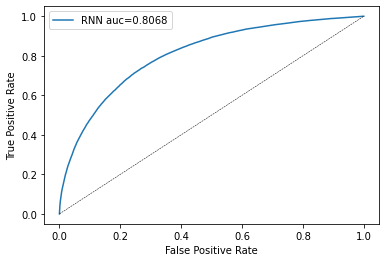

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test, y_pred)

# ROC curve
tpr = TP/(np.sum(test))
fpr = FP/(len(test) - np.sum(test))
tpr_lr = lr_TP/np.sum(test)
fpr_lr = lr_FP/(len(test)-np.sum(test))
plt.plot(fpr, tpr, label=f'RNN auc={auc:.4f}')
plt.plot(np.arange(0, 1.001, 0.001), np.arange(0, 1.001, 0.001), linestyle='dashed', linewidth=0.5, color='k')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [11]:
f1 = TP/(TP+0.5*(FP+FN))
thresholds[np.argmax(f1)]

0.527

In [20]:
# Significance

# load xs weights
train_weights, test_weights = np.load('./data/weights.npy', allow_pickle=True)

significance_sigma0 = np.zeros(len(thresholds))
significance_sigma5 = np.zeros(len(thresholds))
significance_sigma10 = np.zeros(len(thresholds))

lum = 140e3
sg = np.zeros(len(thresholds))
bg = np.zeros(len(thresholds))
sigma = 0.1
epsilon = 1e-4

for idx, threshold in enumerate(thresholds):
    sg[idx] = (lum * test_weights * 5 * ((y_pred >= threshold) & (test == 1)).astype(int)).sum()
    bg[idx] = (lum * test_weights * 5 * ((y_pred >= threshold) & (test == 0)).astype(int)).sum()
    if bg[idx] > 0:
        significance_sigma0[idx] = sg[idx]/np.sqrt(bg[idx])
        significance_sigma5[idx] = sg[idx]/np.sqrt(bg[idx] + (0.05 * bg[idx])**2)
        significance_sigma10[idx] = sg[idx]/np.sqrt(bg[idx] + (0.1 * bg[idx])**2)
    

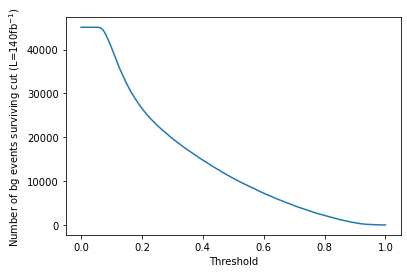

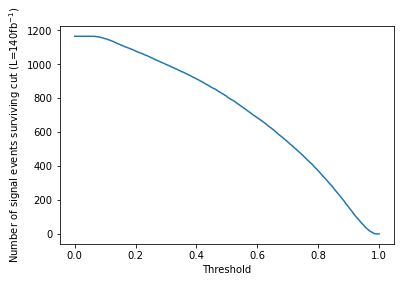

In [17]:
import matplotlib.pyplot as plt

# bg surviving
plt.plot(thresholds, bg)
plt.xlabel("Threshold")
plt.ylabel(r"Number of bg events surviving cut (L=140fb$^{-1}$)")
plt.show()

# sg surviving
plt.plot(thresholds, sg)
plt.xlabel("Threshold")
plt.ylabel(r"Number of signal events surviving cut (L=140fb$^{-1}$)")
plt.show()

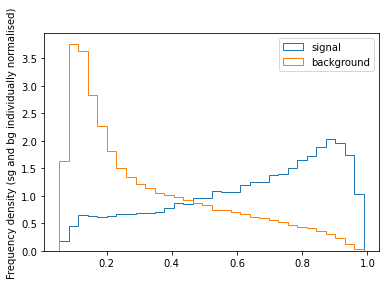

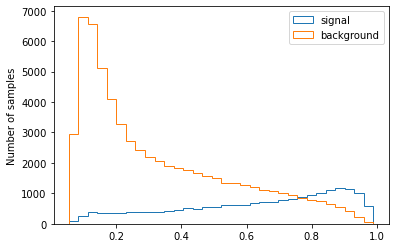

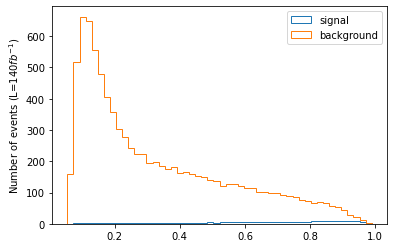

In [18]:
hist_sg, bins, patches = plt.hist(y_pred[y_test[:,-1]==1], histtype='step', label="signal", density=True, bins='auto')
hist_bg, bins, patches = plt.hist(y_pred[y_test[:,-1]==0], histtype='step', label="background", density=True, bins=bins)
plt.ylabel("Frequency density (sg and bg individually normalised)")
plt.legend()
plt.show()

hist_sg_counts, bins_counts, patches = plt.hist(y_pred[y_test[:,-1]==1], histtype='step', label="signal", bins='auto')
hist_bg_counts, bins_counts, patches = plt.hist(y_pred[y_test[:,-1]==0], histtype='step', label="background", bins=bins_counts)
plt.ylabel("Number of samples")
plt.legend()
plt.show()

hist_sg_xs, bins_xs, patches = plt.hist(y_pred[y_test[:,-1]==1], histtype='step', label="signal", bins=50, weights=lum*test_weights[y_test[:,-1]==1])
hist_bg_xs, bins_xs, patches = plt.hist(y_pred[y_test[:,-1]==0], histtype='step', label="background", bins=bins_xs, weights=lum*test_weights[y_test[:,-1]==0])
plt.ylabel(r"Number of events (L=$140fb^{-1}$)")
plt.legend()
plt.show()

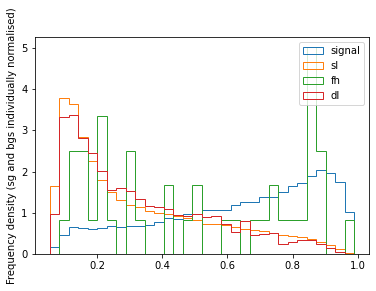

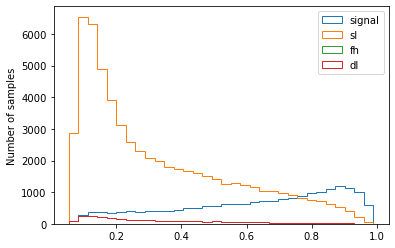

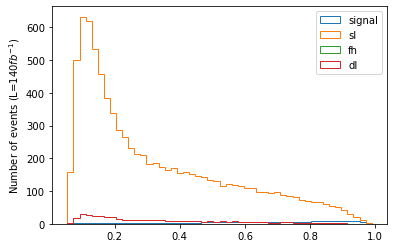

In [28]:
# Individual background analysis

hist_sg, bins, patches = plt.hist(y_pred[y_test[:,-1]==1], histtype='step', label="signal", density=True, bins='auto')
hist_sl, bins, patches = plt.hist(y_pred[y_test[:,-2]==1], histtype='step', label="sl", density=True, bins=bins)
hist_fh, bins, patches = plt.hist(y_pred[y_test[:,-3]==1], histtype='step', label="fh", density=True, bins=bins)
hist_dl, bins, patches = plt.hist(y_pred[y_test[:,0]==1], histtype='step', label="dl", density=True, bins=bins)
plt.ylabel("Frequency density (sg and bgs individually normalised)")
plt.legend()
plt.show()

hist_sg_counts, bins_counts, patches = plt.hist(y_pred[y_test[:,-1]==1], histtype='step', label="signal", bins='auto')
hist_sl_counts, bins_counts, patches = plt.hist(y_pred[y_test[:,-2]==1], histtype='step', label="sl", bins=bins_counts)
hist_fh_counts, bins_counts, patches = plt.hist(y_pred[y_test[:,-3]==1], histtype='step', label="fh", bins=bins_counts)
hist_dl_counts, bins_counts, patches = plt.hist(y_pred[y_test[:,0]==1], histtype='step', label="dl", bins=bins_counts)
plt.ylabel("Number of samples")
plt.legend()
plt.show()

hist_sg_xs, bins_xs, patches = plt.hist(y_pred[y_test[:,-1]==1], histtype='step', label="signal", weights=140e3*test_weights[y_test[:,-1]==1], bins=50)
hist_sl_xs, bins_xs, patches = plt.hist(y_pred[y_test[:,-2]==1], histtype='step', label="sl", weights=140e3*test_weights[y_test[:,-2]==1], bins=bins_xs)
hist_fh_xs, bins_xs, patches = plt.hist(y_pred[y_test[:,-3]==1], histtype='step', label="fh", weights=140e3*test_weights[y_test[:,-3]==1], bins=bins_xs)
hist_dl_xs, bins_xs, patches = plt.hist(y_pred[y_test[:,0]==1], histtype='step', label="dl", weights=140e3*test_weights[y_test[:,0]==1], bins=bins_xs)
plt.ylabel(r"Number of events (L=$140fb^{-1}$)")
plt.legend()
plt.show()

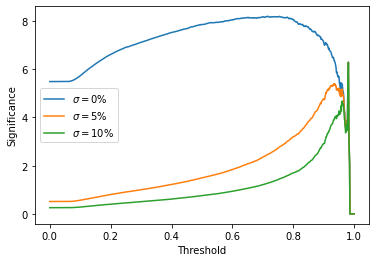

In [21]:
plt.plot(thresholds, significance_sigma0, label=r"$\sigma=0\%$")
plt.plot(thresholds, significance_sigma5, label=r"$\sigma=5\%$")
plt.plot(thresholds, significance_sigma10, label=r"$\sigma=10\%$")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
plt.show()

Best threshold for sigma=0% is 0.717 
Best threshold for sigma=5% is 0.981 
Best threshold for sigma=10% is 0.981


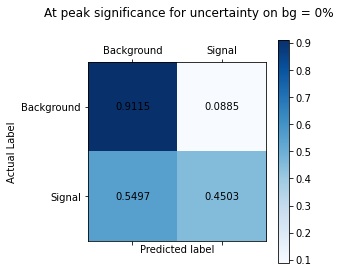

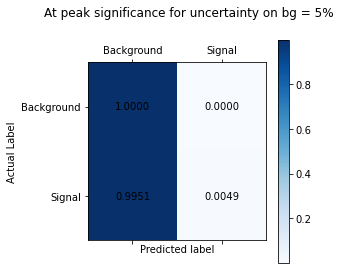

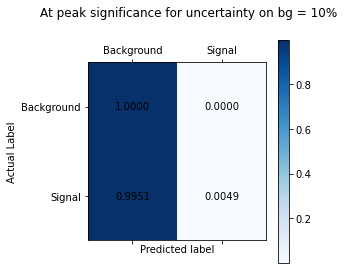

In [22]:
idx_0, idx_5, idx_10 = np.argmax(significance_sigma0), np.argmax(significance_sigma5), np.argmax(significance_sigma10)
print(f"Best threshold for sigma=0% is {thresholds[idx_0]} \nBest threshold for sigma=5% is {thresholds[idx_5]} \nBest threshold for sigma=10% is {thresholds[idx_10]}")
label = {0: 0, 1: 5, 2:10}
# idx_sig5 = np.argmin(abs(significance_sigma10-5))

for j, idx in enumerate((idx_0, idx_5, idx_10)):
    conf_mat = [[1-fpr[idx], fpr[idx]], [1-tpr[idx], tpr[idx]]]
    plt.matshow(conf_mat, cmap='Blues')
    for (x, y), value in np.ndenumerate(conf_mat):
        plt.text(y, x, f"{value:.4f}", va="center", ha="center")
    plt.xlabel('Predicted label')
    plt.ylabel('Actual Label')
    plt.xticks([0,1], labels=['Background', 'Signal'])
    plt.yticks([0,1], labels=['Background', 'Signal'])
    plt.colorbar()
    plt.suptitle(f"At peak significance for uncertainty on bg = {label[j]}%")
    # plt.savefig(f"./first_lstm_conf_mat_sigma_{label[j]}.png", dpi=200)
    plt.show()

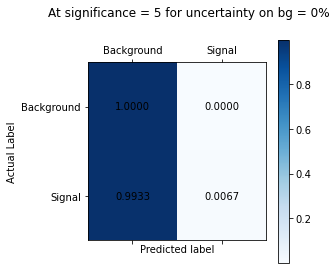

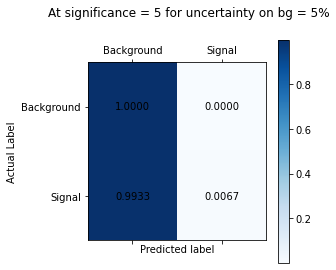

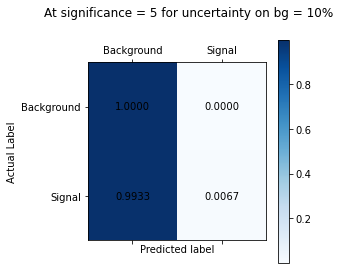

In [25]:
# conf matrices @ sig=5

idx_0, idx_5, idx_10 = np.argmin(abs(5-significance_sigma0)), np.argmin(abs(5-significance_sigma5[:idx_5])), np.argmin(abs(5-significance_sigma10[:idx_10]))
# print(f"Best threshold for sigma=0% is {thresholds[idx_0]} \nBest threshold for sigma=5% is {thresholds[idx_5]} \nBest threshold for sigma=10% is {thresholds[idx_10]}")
label = {0: 0, 1: 5, 2:10}
# idx_sig5 = np.argmin(abs(significance_sigma10-5))

for j, idx in enumerate((idx_0, idx_5, idx_10)):
    conf_mat = [[1-fpr[idx], fpr[idx]], [1-tpr[idx], tpr[idx]]]
    plt.matshow(conf_mat, cmap='Blues')
    for (x, y), value in np.ndenumerate(conf_mat):
        plt.text(y, x, f"{value:.4f}", va="center", ha="center")
    plt.xlabel('Predicted label')
    plt.ylabel('Actual Label')
    plt.xticks([0,1], labels=['Background', 'Signal'])
    plt.yticks([0,1], labels=['Background', 'Signal'])
    plt.colorbar()
    plt.suptitle(f"At significance = 5 for uncertainty on bg = {label[j]}%")
    # plt.savefig(f"./first_lstm_conf_mat_sigma_{label[j]}_sig_5.png", dpi=200)
    plt.show()